# 数字图像处理-血细胞识别

#### 1.首先对数据集进行探索
这里编写读取数据集所用到的函数

In [22]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from lxml import etree
CELL_NAMES = ['RBC', 'WBC', 'Platelets']# 红细胞，白细胞，血小板
train_path = 'BCCD/BCCD/Annotations'

返回一个字典，将类别转为数字，便于后面的分类

字典是{'RBC': 0, 'WBC': 1, 'Platelets': 2}

In [23]:
def get_cell_names():
    cell_id = {}
    for i, item in enumerate(CELL_NAMES):
        cell_id[item] = i
    return cell_id

展示图片

In [3]:
def show(img):
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

获得数据集列表  (读取xml文件)

In [24]:
def get_annotations(cname2cid, datadir):
    # 获取全部xml文件名
    filenames = os.listdir(datadir)
    records = []  # 保存对象具体信息
    # 遍历全部xml文件
    for fname in filenames[1:]:
        # 保存该xml文件路径+文件名
        fpath = os.path.join(datadir, fname)
        # 生成对应xml文件的图像路径
        img_file = os.path.join("BCCD/BCCD/JPEGImages/", fname.split(".")[0] + ".jpg")
        
        tree = etree.parse(datadir + "/" + fname)  # 生成解析xml对象
        objs = tree.xpath("//object")  # 获取当前图像中全部血细胞对象
        # 获取图像宽高
        im_w = float(tree.xpath('//size')[0].xpath('width')[0].text)  
        im_h = float(tree.xpath('//size')[0].xpath('height')[0].text)
        gt_bbox = np.zeros((len(objs), 4), dtype=np.float32)  # 生成保存对象的数组
        gt_class = np.zeros((len(objs),), dtype=np.int32)  # 生成保存对象类别的数组
        is_crowd = np.zeros((len(objs),), dtype=np.int32)  # 生成
        difficult = np.zeros((len(objs),), dtype=np.int32)
        for i, obj in enumerate(objs):  # 遍历全部对象
            cname = obj.xpath('.//name')[0].text  # 获取对象类别名称
            gt_class[i] = cname2cid[cname]  # 类别名转为数值并添加到数组
            _difficult = int(obj.xpath('.//difficult')[0].text)
            x1 = float(obj.xpath('.//bndbox')[0].xpath('./xmin')[0].text)  # 获取对象框的左上角和右下角的坐标
            y1 = float(obj.xpath('.//bndbox')[0].xpath('./ymin')[0].text)
            x2 = float(obj.xpath('.//bndbox')[0].xpath('./xmax')[0].text)
            y2 = float(obj.xpath('.//bndbox')[0].xpath('./ymax')[0].text)
            x1 = max(0, x1)
            y1 = max(0, y1)
            x2 = min(im_w - 1, x2)
            y2 = min(im_h - 1, y2)
            # 这里使用xywh格式来表示目标物体真实框
            gt_bbox[i] = [(x1 + x2) / 2.0, (y1 + y2) / 2.0, x2 - x1 + 1., y2 - y1 + 1.]
            is_crowd[i] = 0
            difficult[i] = _difficult

        # 保存当前图像具体信息的字典
        voc_rec = {
            'im_file': img_file,
            'h': im_h,
            'w': im_w,
            'is_crowd': is_crowd,
            'gt_class': gt_class,
            'gt_bbox': gt_bbox,
            'gt_poly': [],
            'difficult': difficult
        }
        # 若该图像包含对象至少一个则将其追加到列表
        if len(objs) != 0:
            records.append(voc_rec)
    return records

对于一般的检测任务来说，一张图片上往往会有多个目标物体

设置参数MAX_NUM = 50， 即一张图片最多取50个真实框；如果真实，框的数目少于50个，则将不足部分的gt_bbox, gt_class和gt_score的各项数值全设置为0

这里是获取标注框的函数，用于获取标注框的位置以及标注类别，同时将每个图像的框的数目归一化

In [5]:
def get_bbox(gt_bbox, gt_class):
    MAX_NUM = 50
    gt_bbox2 = np.zeros((MAX_NUM, 4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i, :] = gt_bbox[i, :]
        gt_class2[i] = gt_class[i]
        if i >= MAX_NUM:
            break
    return gt_bbox2, gt_class2

获取图片数据

In [25]:
def get_img_data_from_file(record):
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt_boxes, gt_labels = get_bbox(gt_bbox, gt_class)

    # gt_bbox 用相对值
    gt_boxes[:, 0] = gt_boxes[:, 0] / float(w)
    gt_boxes[:, 1] = gt_boxes[:, 1] / float(h)
    gt_boxes[:, 2] = gt_boxes[:, 2] / float(w)
    gt_boxes[:, 3] = gt_boxes[:, 3] / float(h)

    return img, gt_boxes, gt_labels, (h, w)

给出框的位置，绘制标注框，标注类别

In [26]:
def rectangle_draw(img, gt_boxes, gt_class, size):
    """
    #给图像中的细胞绘制矩形框和文字标注
    """
    # 将位置相对值转为绝对值

    gt_boxes[:, 0] = gt_boxes[:, 0] * size[1]
    gt_boxes[:, 1] = gt_boxes[:, 1] * size[0]
    gt_boxes[:, 2] = gt_boxes[:, 2] * size[1]
    gt_boxes[:, 3] = gt_boxes[:, 3] * size[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, g_b in enumerate(gt_boxes):
        font_x_y = (int(g_b[0]), int(g_b[1]))  #字体显示位置坐标
        x1 = int(g_b[0]) - int(g_b[2] / 2)
        y1 = int(g_b[1]) - int(g_b[3] / 2)
        x2 = int(g_b[0]) + int(g_b[2] / 2)
        y2 = int(g_b[1]) + int(g_b[3] / 2)
        if gt_class[i] == 0:
            color = (0,0,255)
            cv2.putText(img, "RBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        elif gt_class[i] == 1:
            color = (255,0,0)
            cv2.putText(img, "WBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)

        else:
            color = (0,255,0)
            cv2.putText(img, "Platelets", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        cv2.rectangle(img, (x1,y1), (x2,y2), color)

In [8]:
def circle_draw(img, gt_boxes, gt_class, size):
    import math
    """
    #给图像中的细胞绘制圆形框和文字标注
    """
    # 将位置相对值转为绝对值
    gt_boxes[:, 0] = gt_boxes[:, 0] * size[1]
    gt_boxes[:, 1] = gt_boxes[:, 1] * size[0]
    gt_boxes[:, 2] = gt_boxes[:, 2] * size[1]
    gt_boxes[:, 3] = gt_boxes[:, 3] * size[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i, g_b in enumerate(gt_boxes):
        font_x_y = (int(g_b[0]), int(g_b[1]))  # 字体显示位置坐标
        x = int(g_b[0])
        y = int(g_b[1])
        w = int(g_b[2])
        h = int(g_b[3])
        r = int(math.sqrt(w*w + h*h)/3)
        if gt_class[i] == 0:
            color = (0, 0, 255)
            cv2.putText(img, "RBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        elif gt_class[i] == 1:
            color = (255, 0, 0)
            cv2.putText(img, "WBC", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)

        else:
            color = (0, 255, 0)
            cv2.putText(img, "Platelets", font_x_y, font, 0.5, color, 1, cv2.LINE_AA)
        cv2.circle(img, (x,y), (r), color)

##### 2.首先查看一下正常图片和标注后的图片

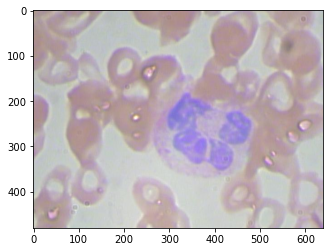

In [99]:
cname2cid = get_cell_names()
records = get_annotations(cname2cid,train_path)
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[0])

plt.imshow(img)

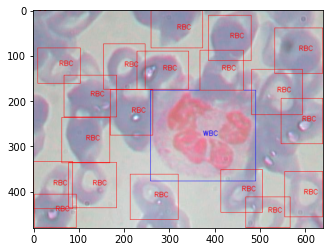

In [100]:
img_new = img.copy()
rectangle_draw(img_new, gt_boxes, gt_labels, scales)
show(img_new)

可以大致看出白细胞比较大，中心有蓝紫色细胞核，而红细胞相对较小且中心发白(没有细胞核)，血小板则非常小。

这里是提取单个目标图像函数和测试效果

19 1 0


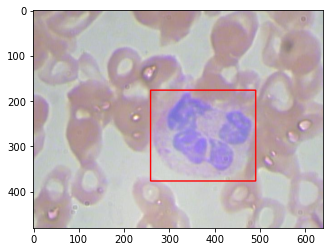

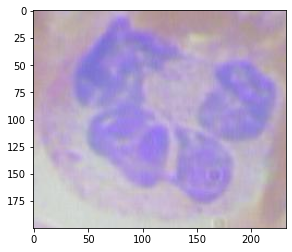

In [101]:
def get_samples(record):
    img, gt_boxes, gt_labels, scales = get_img_data_from_file(record)
    RBC = []
    WBC = []
    Platelets = []
    for num in range(len(gt_labels)):
        i =  gt_boxes[num]
        j = gt_labels[num]
        
        x1 = int((i[0]-i[2]/2)*scales[1])
        y1 = int((i[1]-i[3]/2)*scales[0])
        x2 = int((i[0]+i[2]/2)*scales[1])
        y2 = int((i[1]+i[3]/2)*scales[0])
        if j==0.0:
            if x2*y2!=0.0:
                RBC.append((img[y1:y2,x1:x2,],(x1,y1,x2,y2)))
        if j==1.0:
            WBC.append((img[y1:y2,x1:x2,],(x1,y1,x2,y2)))
        if j==2.0:
            Platelets.append((img[y1:y2,x1:x2,],(x1,y1,x2,y2)))
    return RBC,WBC,Platelets
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[0])
RBC,WBC,Platelets = get_samples(records[0])
print(len(RBC),len(WBC),len(Platelets))
img_temp = WBC[0][0]
x1,y1,x2,y2 = WBC[0][1]
dots = np.array([[x1,y1],[x1,y2],[x2,y2],[x2,y1]],dtype=np.int32)
img_temp1 = cv2.polylines(img,[dots],True,(255,0,0),2)
plt.imshow(img_temp1)
plt.show()
plt.imshow(img_temp)
plt.show()

图中可以看出分割得到的白细胞模板，红细胞和血小板也是一样。

#### 2.细胞识别与标注
细胞标注需要有每个细胞的特征，使用提取出来的细胞特征进行模板匹配，根据相似度进行匹配得到最终的标注结果。

##### 获取模板

这里选取前20个数据用于模板提取。

In [102]:
train = [records[4]]

In [103]:
ls_RBC=[]
ls_WBC=[]
ls_Platelets=[]
for i in train:
    RBC,WBC,Platelets = get_samples(i)
    ls_RBC.extend(RBC)
    ls_WBC.extend(WBC)
    ls_Platelets.extend(Platelets)
print(len(ls_RBC))
print(len(ls_WBC))
print(len(ls_Platelets))

11
1
1


首先进行红细胞的识别

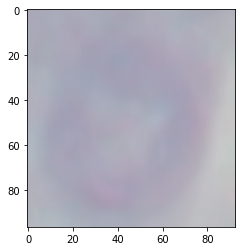

In [104]:
# 获取模板列表
ls_img = [i[0] for i in ls_RBC]
ls_loc = np.array([list(i[1]) for i in ls_RBC])
# x1,y1,x2,y2 = 
w = int(np.mean(ls_loc[:,2]-ls_loc[:,0]))
h = int(np.mean(ls_loc[:,3]-ls_loc[:,1]))
RBC_model = np.zeros((w,h,3),dtype=np.float32)
for i in ls_img:
    RBC_model += cv2.resize(i,(h,w),interpolation=cv2.INTER_LINEAR)
RBC_model = RBC_model/len(ls_img)
RBC_model=RBC_model.astype("uint8")
show(RBC_model)

In [105]:
RBC_model.shape

(97, 93, 3)

使用模板匹配一张图像

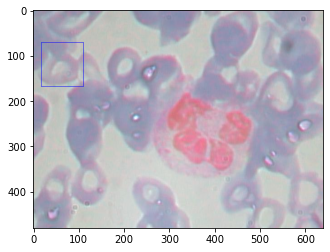

In [106]:
def match(img,model):
    # width,height = img.shape[0]
    w,h = model.shape[1],model.shape[0]
    res = cv2.matchTemplate(img,model,1)
    min_v,max_v,min_l,max_l = cv2.minMaxLoc(res)
    top_left = min_l
    bottom_right = [top_left[0]+w,top_left[1]+h]
    return top_left,bottom_right
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[0])
top_left,bottom_right = match(img,RBC_model)
show(cv2.rectangle(img,top_left,bottom_right ,(255,0,0)))


可以看到，蓝框标注的即为红细胞。

同理可以进行白细胞，血小板的标注

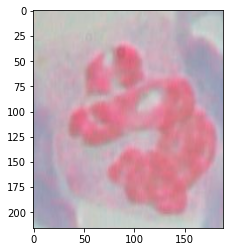

In [107]:
# 获取模板列表
ls_img = [i[0] for i in ls_WBC]
ls_loc = np.array([list(i[1]) for i in ls_WBC]) 
w = int(np.mean(ls_loc[:,2]-ls_loc[:,0]))
h = int(np.mean(ls_loc[:,3]-ls_loc[:,1]))
WBC_model = np.zeros((w,h,3),dtype=np.float32)
for i in ls_img:
    WBC_model += cv2.resize(i,(h,w),interpolation=cv2.INTER_LINEAR)
WBC_model = WBC_model/len(ls_img)
WBC_model=WBC_model.astype("uint8")
show(WBC_model)

接下来进行白细胞的标注

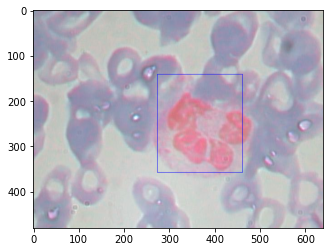

In [108]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[0])
top_left,bottom_right = match(img,WBC_model)
show(cv2.rectangle(img,top_left,bottom_right ,(255,0,0)))

也成功匹配到了白细胞。

最后是血小板的标注

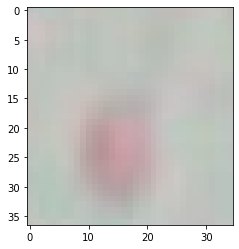

In [109]:
ls_img = [i[0] for i in ls_Platelets]
ls_loc = np.array([list(i[1]) for i in ls_Platelets]) 
w = int(np.mean(ls_loc[:,2]-ls_loc[:,0]))
h = int(np.mean(ls_loc[:,3]-ls_loc[:,1]))
Platelets_model = np.zeros((w,h,3),dtype=np.float32)
for i in ls_img:
    Platelets_model += cv2.resize(i,(h,w),interpolation=cv2.INTER_LINEAR)
Platelets_model = Platelets_model/len(ls_img)
Platelets_model=Platelets_model.astype("uint8")
show(Platelets_model)

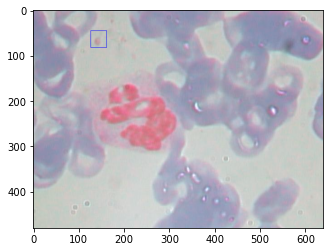

In [110]:
img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[4])
top_left,bottom_right = match(img,Platelets_model)
show(cv2.rectangle(img,top_left,bottom_right ,(255,0,0)))

血小板的标注也能够完成

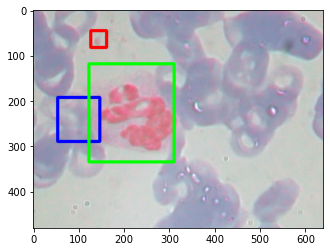

done


In [111]:
def vision(img,i):
    top_left_P,bottom_right_P = match(img,Platelets_model)
    top_left_W,bottom_right_W = match(img,WBC_model)
    top_left_R,bottom_right_R = match(img,RBC_model)
    img = cv2.rectangle(img,top_left_R,bottom_right_R ,(255,0,0),5)
    img = cv2.rectangle(img,top_left_W,bottom_right_W ,(0,255,0),5)
    img = cv2.rectangle(img,top_left_P,bottom_right_P ,(0,0,255),5)
    #cv2.imwrite(f"/data/{i}.png",img)
    show(img)

img, gt_boxes, gt_labels, scales = get_img_data_from_file(records[4])
vision(img,i)
print("done")

In [112]:
cv2.imwrite("data/sample.png",img)

True

最终结果如图所示

#### 实验结果与不足
- 基本能够识别三种不同的血细胞
- 由于识别是基于模板匹配的方法，精度可能会较差，使用阈值进行判断时结果非常混乱，所以就没有采用。
- 对于一些形状不规则的细胞可能不能精确识别